In [1]:
from loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
loader = ThoraxDataLoader("../Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
y_dataset = loader.load_all_samples("HS")
newcmp = loader.newcmp

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

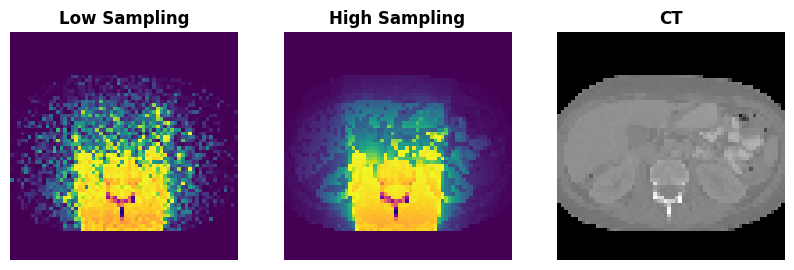

In [3]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS = LS_dataset[val_lenght,:,:]
CT = CT_dataset[val_lenght,:,:]
HS = y_dataset[val_lenght,:,:]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None, cmap=newcmp)
axes[0].set_title('Low Sampling', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HS, interpolation=None, cmap=newcmp)
axes[1].set_title('High Sampling', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(CT, interpolation=None, cmap='gray')
axes[2].set_title('CT', fontweight='bold')
axes[2].axis('off')

plt.show()

In [4]:
import os
import segmentation_models_pytorch as smp
import torch

c:\Users\CS\Documents\Projet_Radiotherapie\projet_S7_radio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
current_dir = os.getcwd()

target_dir = os.path.abspath(os.path.join(current_dir, "unet-with-transform",))
print(target_dir)

# Charger le modèle pré-entraîné
model = smp.from_pretrained(target_dir)

os.chdir(current_dir)

# Modifier les paramètres pour accepter 2 canaux en entrée
model_init_params = {
    "encoder_name": "resnet34",
    "encoder_depth": 5,
    "encoder_weights": "imagenet",
    "decoder_use_batchnorm": True,
    "decoder_channels": (256, 128, 64, 32, 16),
    "decoder_attention_type": None,
    "in_channels": 2,  # Modifier pour 2 canaux en entrée
    "classes": 1,       # Une seule image en sortie
    "activation": None,
    "aux_params": None
}


c:\Users\CS\Documents\Projet_Radiotherapie\projet_S7_radio\Transformer Final\unet-with-transform
Loading weights from local directory


In [6]:
# Reconstruire le modèle avec les nouveaux paramètres
model = smp.Unet(**model_init_params)

# Vérifier la taille de sortie
test_input = torch.randn(1, 2, 64, 64)  # Batch de 1, 2 canaux, 64x64
output = model(test_input)
print(output.shape)  # Devrait être [1, 1, 64, 64]



torch.Size([1, 1, 64, 64])


In [7]:
for param in model.encoder.parameters():
    param.requires_grad = False  # Geler l'encodeur


In [8]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.L1Loss()  # L1 pour la reconstruction
optimizer = optim.Adam(model.decoder.parameters(), lr=1e-4)  # On entraîne uniquement le décodeur

# Pour entraîner aussi l'encodeur, décommenter la ligne suivante
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [9]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS_train = torch.tensor(LS_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train), dim=1)
y_train = torch.tensor(y_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val), dim=1)
y_val = torch.tensor(y_dataset[train_lenght:val_lenght,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test), dim=1)
y_test = torch.tensor(y_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([4592, 2, 64, 64]),
 torch.Size([4592, 1, 64, 64]),
 torch.Size([656, 2, 64, 64]),
 torch.Size([656, 1, 64, 64]),
 torch.Size([1312, 2, 64, 64]),
 torch.Size([1312, 1, 64, 64]))

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 10
num_epochs = 100  # Augmentez si nécessaire

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Initialiser les gradients

            outputs = model(inputs)  # Passage dans le modèle
            loss = criterion(outputs, targets)  # Calcul de la perte

            loss.backward()  # Rétropropagation
            optimizer.step()  # Mise à jour des poids

            running_loss += loss.item()
            if (i + 1) % 115 == 0:  # Affichage toutes les 115 itérations
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")

        evaluate_model(model, val_loader, criterion, device)  # Évaluation sur validation

# Fonction d'évaluation
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

# Lancer l'entraînement
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# Sauvegarde du modèle
torch.save(model.state_dict(), "UNet_finetuned.pth")
print("Entraînement terminé et modèle sauvegardé.")

Epoch [1/100], Batch [115/460], Loss: 0.0024
Epoch [1/100], Batch [230/460], Loss: 0.0028
Epoch [1/100], Batch [345/460], Loss: 0.0031
Epoch [1/100], Batch [460/460], Loss: 0.0041
Validation Loss: 0.0141
Epoch [2/100], Batch [115/460], Loss: 0.0028
Epoch [2/100], Batch [230/460], Loss: 0.0028
Epoch [2/100], Batch [345/460], Loss: 0.0031
Epoch [2/100], Batch [460/460], Loss: 0.0037
Validation Loss: 0.0144
Epoch [3/100], Batch [115/460], Loss: 0.0030
Epoch [3/100], Batch [230/460], Loss: 0.0027
Epoch [3/100], Batch [345/460], Loss: 0.0027
Epoch [3/100], Batch [460/460], Loss: 0.0045
Validation Loss: 0.0144
Epoch [4/100], Batch [115/460], Loss: 0.0026
Epoch [4/100], Batch [230/460], Loss: 0.0026
Epoch [4/100], Batch [345/460], Loss: 0.0030
Epoch [4/100], Batch [460/460], Loss: 0.0044
Validation Loss: 0.0082
Epoch [5/100], Batch [115/460], Loss: 0.0030
Epoch [5/100], Batch [230/460], Loss: 0.0026
Epoch [5/100], Batch [345/460], Loss: 0.0025
Epoch [5/100], Batch [460/460], Loss: 0.0032
Vali

In [26]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

In [27]:
def calculate_psnr(original, reconstructed, data_range=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return np.inf
    psnr = 10*np.log10(data_range**2 / mse)
    return psnr

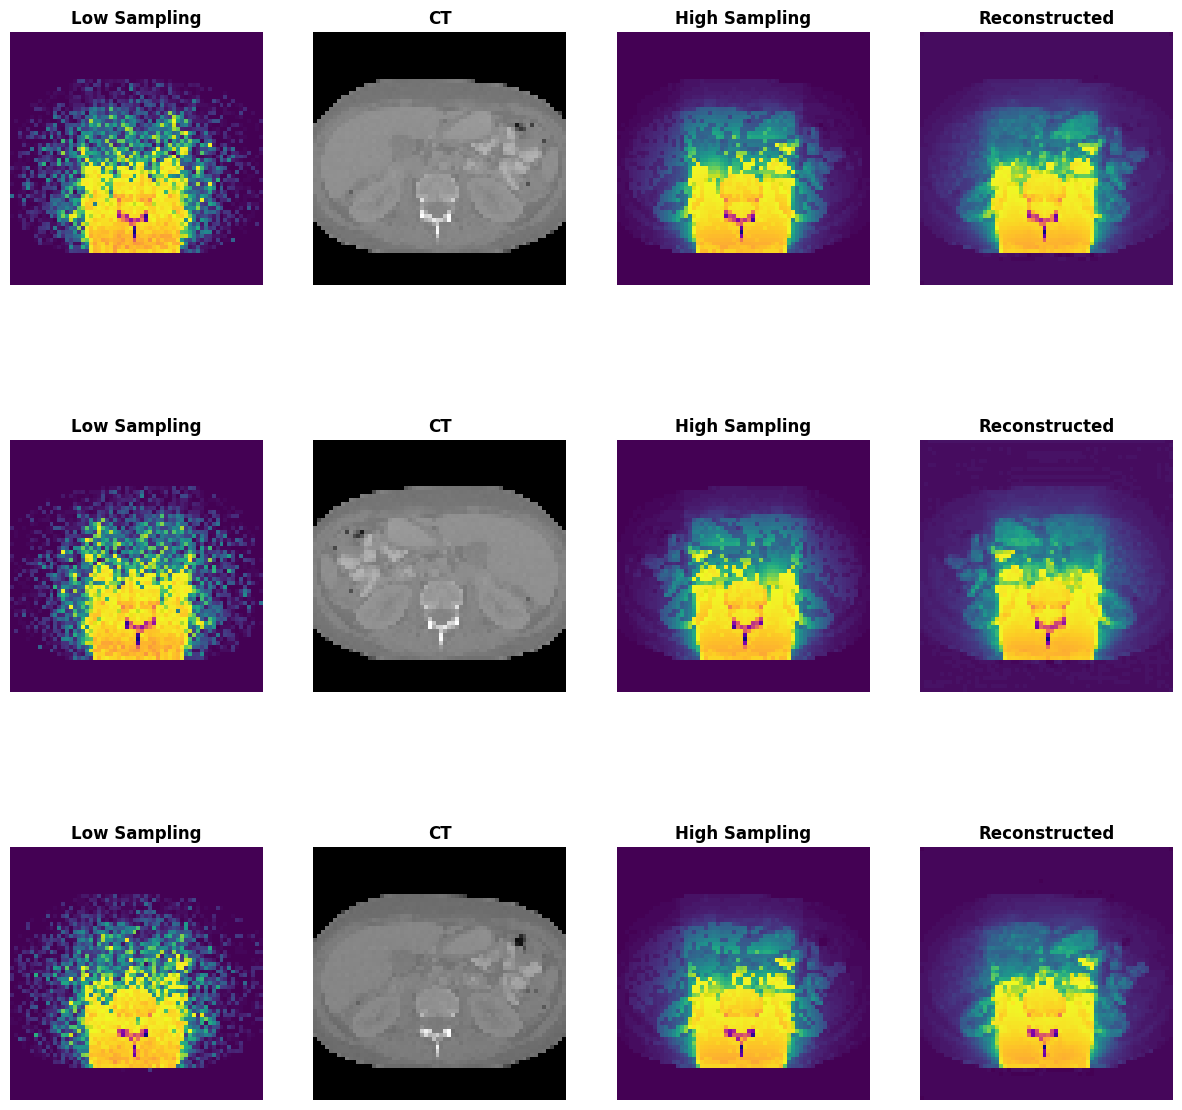

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacez le modèle sur l'appareil approprié
model = model.to(device)

# Déplacez les données d'entrée sur le même appareil que le modèle
x_test = x_test.to(device)

# Effectuez la prédiction
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu()  # Revenir sur CPU si nécessaire pour l'évaluation

y_pred2 = y_pred.cpu().squeeze(1).numpy()
y_test2 = y_test.cpu().squeeze(1).numpy()

fig, axes = plt.subplots(3, 4, figsize=(15, 15))
k = 0 # Pour visualiser d'autres exemples
for i in range(3):
    axes[i, 0].imshow(x_test[i+k, 0].cpu().numpy(), cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test[i+k, 1].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[i+k], cmap=newcmp)
    axes[i, 2].set_title('High Sampling', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred2[i+k], cmap=newcmp)
    axes[i, 3].set_title('Reconstructed', fontweight='bold')
    axes[i, 3].axis('off')

In [24]:
mean_psnr = np.mean([calculate_psnr(y_test2[i], y_pred2[i]) for i in range(len(y_test2))])
print(f"Mean PSNR: {mean_psnr:.2f} dB")

Mean PSNR: 37.74 dB
